# Image processing
This notebook details how the video stream is processed before entering the neural network.

In [1]:
import numpy as np
import dlib
import heartsight as hs
import cv2
import matplotlib.pyplot as plt

## Webcam recording

In [13]:
face_buffer_list = []

with hs.open_webcam() as webcam:

    exit_requested = False
    previous_face_rectangle = None
    while not exit_requested:
        rgb_frame = hs.capture_frame(webcam)
        gray_frame = hs.rgb_to_gray(rgb_frame)
        detected_faces = face_detector(gray_frame, 1)

        face_rectangle = detected_faces[0] if detected_faces else previous_face_rectangle

        if face_rectangle:
            x,y,w,h = hs.dlib_rectangle_to_xywh(face_rectangle)
            face_frame = cv2.resize(rgb_frame[y:y+h, x:x+w], (facebox_width, facebox_width))
            hs.refresh_display(face_frame)
            face_buffer_list.append(face_frame)
            previous_face_rectangle = face_rectangle
        
        exit_requested = hs.detect_q_key_pressed()

face_buffer = np.stack(face_buffer_list)


In [2]:
sample1 = hs.record_sample()

In [3]:
sample1['fps']

28.762540261493484

## Face extraction

In [27]:

face_detector = hs.create_face_detector()
previous_face_rectangle = None
facebox_width=128

frames = sample1['frames']

face_frames_buffer = []
for frame in frames:
    detected_faces = face_detector(frame)
    face_rectangle = detected_faces[0] if detected_faces else previous_face_rectangle
    
    if face_rectangle:
        face_frame = dlib.resize_image(dlib.sub_image(frame, face_rectangle), facebox_width, facebox_width)
        face_frames_buffer.append(face_frame)

In [4]:
face_frames = hs.extract_face_frames(sample1['frames'])

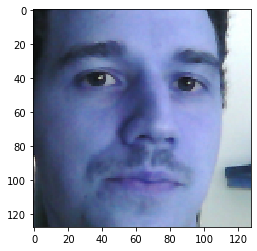

In [7]:
plt.imshow(face_frames[-1])
plt.show()

## First tests with FFT

In [8]:
Y = np.fft.fft(face_frames, axis=0)
Y.shape

(311, 128, 128, 3)

In [9]:
freq = np.fft.fftfreq(face_frames.shape[0], 1/sample1['fps'])
freq.shape

(311,)

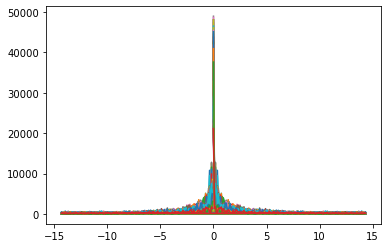

In [10]:
Y_reshaped = Y.reshape((Y.shape[0], -1, 3))

plt.figure()
for i_point in range(0, Y_reshaped.shape[1], 100):
    plt.plot(freq, np.abs(Y_reshaped[:, i_point, 0]))
plt.show()

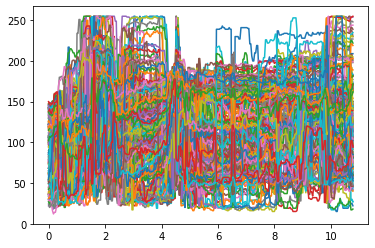

In [11]:
reshaped_frames = face_frames.reshape(face_frames.shape[0], -1, 3)
plt.figure()
for i_point in range(0, reshaped_frames.shape[1], 100):
    plt.plot(np.arange(face_frames.shape[0]/sample1['fps'], step=1/sample1['fps']), reshaped_frames[:, i_point, 1])
plt.show()